# PW5 – Wellenoptik

## Experiment 1 – Beugung am Einzelspalt

### Grundlagen

Bei der **Fraunhofer-Beugung am Einzelspalt** wird kohärentes Licht (z. B. eines Lasers) auf einen schmalen Spalt der Breite $b$ gerichtet.  
Hinter dem Spalt überlagern sich die Elementarwellen nach dem **Huygens-Fresnel-Prinzip**, wodurch ein charakteristisches Intensitätsmuster aus hellen und dunklen Streifen entsteht.

Die **Bedingung für die Minima** der Intensitätsverteilung lautet:

$$
b \sin(\alpha_{\text{min},n}) = n \lambda, \quad n = 1,2,3,\dots
$$

Für kleine Beugungswinkel gilt $\sin(\alpha) \approx \alpha$, daher folgt:

$$
b \, \alpha_{\text{min},n} \approx n \lambda
$$

Die Maxima liegen zwischen den Minima bei:

$$
b \sin(\alpha_{\text{max},n}) = \frac{2n+1}{2} \lambda
$$

Die Intensitätsverteilung ergibt sich aus:

$$
I(\alpha) = I_0 \left( \frac{\sin(\beta)}{\beta} \right)^2,
\quad \text{mit} \quad
\beta = \frac{\pi b \sin(\alpha)}{\lambda}.
$$

### Durchführung

Ein Diodenlaser mit Wellenlänge $\lambda = 635\,\text{nm}$ beleuchtet einen Einzelspalt.  
Das Beugungsbild wird auf einem Schirm beobachtet und die Abstände der Minima symmetrisch zur zentralen Maxima gemessen.  
Zur Vermeidung von Nullpunktfehlern werden die Abstände zwischen den Minima gleicher Ordnung auf beiden Seiten gemessen und halbiert.  

Aus dem Abstand $y_n$ des n-ten Minimums und der Entfernung $L$ zwischen Spalt und Schirm ergibt sich der Winkel:

$$
\alpha_n \approx \tan^{-1}\!\left(\frac{y_n}{L}\right) \approx \frac{y_n}{L}.
$$

Ein Diagramm $\alpha_n$ gegen $n$ liefert durch lineare Regression die Steigung $\lambda/b$.


### Auswertung

Die lineare Regression der gemessenen Daten ergibt:

$$
\alpha_n = \frac{\lambda}{b} \, n.
$$

Damit folgt für die Spaltbreite:

$$
b = \frac{\lambda}{\text{Steigung}}.
$$

Zur Qualität der Regression wird das Bestimmtheitsmaß $R^2$ angegeben.  
Die Unsicherheit von $b$ ergibt sich aus der Standardabweichung der Regressionsparameter.

Gewichteter linearer Fit: alpha = s*n + c
  s = 2.149 +/- 0.009 mrad/Ordnung
  R^2 (gewichtet) = 0.9996
  Chi^2 = 4.819, dof = 5, Chi^2/dof = 0.964

Spaltbreite:
  b = 295 +/- 1 um


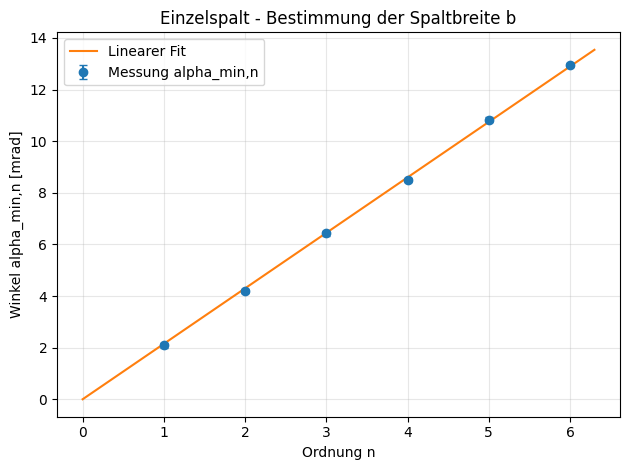

In [27]:
# --- Importe ---
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Hilfsfunktion: schoene Ausgabe im Format "x +/- dx" ---
def pm(val, err):
    if err == 0 or not np.isfinite(err):
        return f"{val:g}"
    k = int(np.floor(np.log10(abs(err))))  # Stelle der ersten signifikanten Ziffer
    r = round(err, -k)                     # Fehler auf eine signifikante Ziffer runden
    fmt = f"{{:.{-k}f}} +/- {{:.{-k}f}}" if k < 0 else "{:.0f} +/- {:.0f}"
    return fmt.format(val, r)

# --- Parameter (anpassen) ---
lambda_nm = 635.0
sigma_lambda_nm = 0.0       # 0 falls vernachlaessigt
L = 1.500                   # m
sigma_L = 0.001

# --- Messdaten: Abstand (-n) bis (+n) in mm ---
data_paare = pd.DataFrame({
    "n": [1, 2, 3, 4, 5, 6],
    "y_double_mm": [12.5, 25.2, 38.55, 51.0, 65.0, 77.65],  
})

df = data_paare.copy()
# Halber Abstand vom Zentrum aus der doppelten Breite
df["y_half_mm"] = df["y_double_mm"] / 2.0
D_mm = df["y_half_mm"].to_numpy()
n = df["n"].to_numpy().astype(float)
sigma_D_mm = np.full_like(D_mm, 0.25)  # Beispiel: 1 mm Unsicherheit

# --- Von D zu Winkeln ---
# y ist der halbe Abstand in Metern (Geometrie: tan(alpha) = y/L)
y = (D_mm * 1e-3) / 2.0
sigma_y = (sigma_D_mm * 1e-3) / 2.0
alpha = np.arctan2(y, L)

# Fehlerfortpflanzung fuer alpha = arctan(y/L)
fac = 1.0 / (1.0 + (y / L) ** 2)               # Ableitungsfaktor der arctan-Kette
sigma_alpha = np.sqrt((fac * (1 / L) * sigma_y) ** 2 +
                      (fac * (-y / L**2) * sigma_L) ** 2)

# --- Gewichteter linearer Fit: alpha = s*n + c ---
x, yv = n, alpha
w = 1.0 / (sigma_alpha ** 2)
enforce_through_origin = True  # True: Fit durch den Ursprung erzwingen

if enforce_through_origin:
    Sxx = np.sum(w * x * x)
    Sxy = np.sum(w * x * yv)
    slope = Sxy / Sxx
    intercept = 0.0
    yhat = slope * x
    res = yv - yhat
    dof = len(x) - 1
    # Varianzskaler fuer Kovarianzmatrix (gewichtete Residuen)
    sigma2_hat = np.sum(w * res**2) / dof
    cov_s = sigma2_hat / Sxx
    slope_stderr = np.sqrt(cov_s)
    intercept_stderr = np.nan
else:
    Sw  = np.sum(w)
    Sx  = np.sum(w * x)
    Sy  = np.sum(w * yv)
    Sxx = np.sum(w * x * x)
    Sxy = np.sum(w * x * yv)
    Delta = Sw * Sxx - Sx**2

    slope = (Sw * Sxy - Sx * Sy) / Delta
    intercept = (Sxx * Sy - Sx * Sxy) / Delta
    yhat = slope * x + intercept
    res = yv - yhat
    dof = len(x) - 2
    sigma2_hat = np.sum(w * res**2) / dof
    cov = sigma2_hat * np.array([[Sxx, -Sx],
                                 [-Sx,  Sw]]) / Delta
    intercept_stderr = np.sqrt(cov[0, 0])
    slope_stderr     = np.sqrt(cov[1, 1])

# --- Chi^2 und Chi^2/dof (gewichteter Fall) ---
chi2 = np.sum(w * res**2)
chi2_red = chi2 / dof

# --- Gewichtetes R^2 (optional, bleibt wie gehabt) ---
ybar_w = np.sum(w * yv) / np.sum(w)
SS_res_w = np.sum(w * res**2)
SS_tot_w = np.sum(w * (yv - ybar_w)**2)
R2 = 1.0 - SS_res_w / SS_tot_w

# --- Steigung in mrad/Ordnung fuer Ausgabe (intern fuer b in rad belassen) ---
slope_mrad = slope * 1e3
slope_stderr_mrad = slope_stderr * 1e3

# --- Spaltbreite b (Formel b = lambda / s; s MUSS in rad sein) ---
s = slope                      # rad/Ordnung
ds = slope_stderr
lam = lambda_nm * 1e-9
dlam = sigma_lambda_nm * 1e-9

b = lam / s
db = np.sqrt( (dlam / s)**2 + (lam * ds / s**2)**2 )

# --- Ausgabe der Ergebnisse ---
print("Gewichteter linearer Fit: alpha = s*n + c")
print(f"  s = {pm(slope_mrad, slope_stderr_mrad)} mrad/Ordnung")
if not enforce_through_origin:
    print(f"  c = {pm(intercept, intercept_stderr)} rad")
print(f"  R^2 (gewichtet) = {R2:.4f}")
print(f"  Chi^2 = {chi2:.3f}, dof = {dof}, Chi^2/dof = {chi2_red:.3f}")

print("\nSpaltbreite:")
print(f"  b = {pm(b * 1e6, db * 1e6)} um")

# --- Darstellung ---
plt.figure()
# y-Achse in mrad plotten
plt.errorbar(x, yv * 1e3, yerr=sigma_alpha * 1e3, fmt='o', capsize=3,
             label="Messung alpha_min,n")
xx = np.linspace(0, 1.05 * np.max(x), 200)
yy = slope * xx + (0 if enforce_through_origin else intercept)
plt.plot(xx, yy * 1e3, label="Linearer Fit")
plt.xlabel("Ordnung n")
plt.ylabel("Winkel alpha_min,n [mrad]")
plt.title("Einzelspalt - Bestimmung der Spaltbreite b")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



## Experiment 2 – Beugung am Doppelspalt

### Grundlagen

Beim **Doppelspalt** interferieren zwei kohärente Teilstrahlen, die durch die Spalte mit Abstand $g$ treten.  
Die Bedingung für **Interferenzmaxima** lautet:

$$
g \sin(\alpha_{\text{max},k}) = k \lambda, \quad k = 0, 1, 2, \dots
$$

und für **Minima**:

$$
g \sin(\alpha_{\text{min},k}) = \frac{2k+1}{2} \lambda.
$$

Bei realistischen Spalten überlagert sich dieses Interferenzmuster mit der Einzelspalt-Hüllkurve der Breite $b$:

$$
I(\alpha) = I_0
\left( \frac{\sin(\beta)}{\beta} \right)^2
\cos^2(\gamma),
\quad
\beta = \frac{\pi b \sin(\alpha)}{\lambda}, \quad
\gamma = \frac{\pi g \sin(\alpha)}{\lambda}.
$$

### Durchführung

Der Diodenlaser ($\lambda = 635\,\text{nm}$) beleuchtet den Doppelspalt senkrecht.  
Das entstehende Beugungs- und Interferenzbild wird auf einem Schirm aufgefangen und die Positionen der Maxima bzw. Minima gemessen.  

Zunächst wird analog zum Einzelspalt aus der Einhüllenden die Spaltbreite $b$ bestimmt.  
Anschließend wird der **Spaltabstand $g$** berechnet, indem gezählt wird, wie viele Interferenzmaxima („zweite Klasse“) innerhalb des zentralen Einzelspaltmaximums („erste Klasse“) auftreten.  
Aus der Relation

$$
\frac{b}{g} \approx \frac{k}{n}
$$

folgt $g = b \, n/k$, wobei $n$ die Ordnung des Minimums I. Klasse und $k$ die Ordnung des Maximums II. Klasse bezeichnet.

### Auswertung

1. Lineare Regression der Einzelspalt-Minima liefert $b$.  
2. Aus der Zahl der Maxima II. Klasse im Hauptmaximum I. Klasse folgt $g$.  
3. Die theoretische Intensitätsverteilung $I(\alpha)$ wird mit den Messwerten verglichen.  

Die gemessenen Parameter $b$ und $g$ werden mit den Herstellerwerten verglichen und der relative Fehler angegeben.

=== Doppelspalt: Bestimmung der Spaltbreite b ===
Steigung s = 6.63 +/- 0.02 mrad/Ordnung
R^2 = 0.9997
Chi^2 = 7.419, dof = 5, Chi^2/dof = 1.484
Spaltbreite b = 95.8 +/- 0.3 um



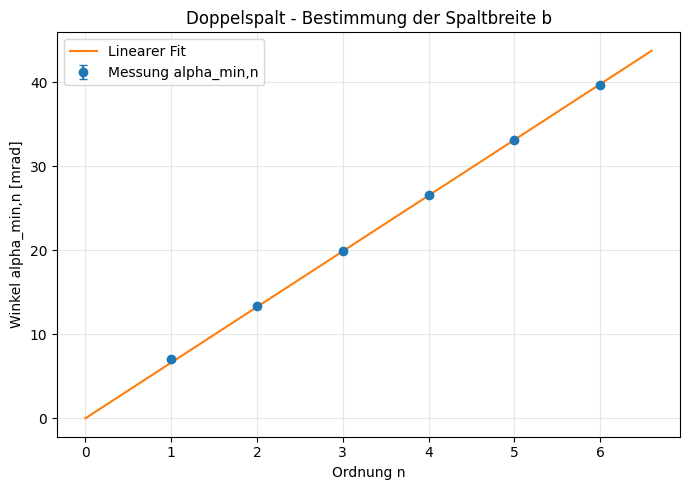

=== Doppelspalt: Bestimmung des Spaltabstands g ===
Steigung s = 1.29 +/- 0.02 mrad/Ordnung
R^2 = 0.9938
Chi^2 = 0.826, dof = 4, Chi^2/dof = 0.206
Spaltabstand g = 494 +/- 8 um



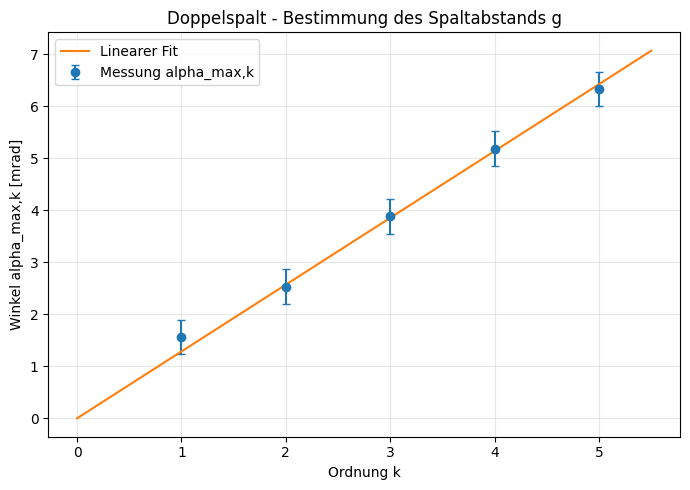

In [30]:
# --- Importe ---
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Hilfsfunktion fuer die Ausgabe im Format "x +/- dx" ---
def pm(val, err):
    if err == 0 or not np.isfinite(err):
        return f"{val:g}"
    k = int(np.floor(np.log10(abs(err))))
    r = round(err, -k)
    fmt = f"{{:.{-k}f}} +/- {{:.{-k}f}}" if k < 0 else "{:.0f} +/- {:.0f}"
    return fmt.format(val, r)

# --- Parameter ---
lambda_nm = 635.0     # nm
sigma_lambda_nm = 0.0
L = 1.500             # m
sigma_L = 0.001       # m

# ================================================================
#   TEIL 1: Doppelspalt – Bestimmung der Spaltbreite b
# ================================================================
data_minima = pd.DataFrame({
    "n": [1, 2, 3, 4, 5, 6],
    "y_double_mm": [21.1, 40.15, 59.8, 79.7, 99.2, 119.0],   
})
sigma_y_mm = 0.25

df_b = data_minima.copy()
df_b["y_half_mm"] = df_b["y_double_mm"] / 2.0
df_b["sigma_y_half_mm"] = sigma_y_mm

n = df_b["n"].to_numpy(dtype=float)
y_b_m = df_b["y_half_mm"].to_numpy(dtype=float) * 1e-3
sigma_y_b_m = df_b["sigma_y_half_mm"].to_numpy(dtype=float) * 1e-3

# --- Winkel alpha (aus Geometrie tan(alpha)=y/L) und Fehler ---
alpha_b = np.arctan2(y_b_m, L)
fac_b = 1.0 / (1.0 + (y_b_m / L) ** 2)
sigma_alpha_b = np.sqrt((fac_b * (1 / L) * sigma_y_b_m) ** 2 +
                        (fac_b * (-y_b_m / L ** 2) * sigma_L) ** 2)

# --- Gewichtete Regression durch Ursprung: alpha = s * n ---
x_b, yv_b, w_b = n, alpha_b, 1.0 / (sigma_alpha_b ** 2)
Sxx_b = np.sum(w_b * x_b * x_b)
Sxy_b = np.sum(w_b * x_b * yv_b)
slope_b = Sxy_b / Sxx_b                         # rad / Ordnung
res_b = yv_b - slope_b * x_b
dof_b = len(x_b) - 1
sigma2_hat_b = np.sum(w_b * res_b ** 2) / dof_b
slope_b_err = np.sqrt(sigma2_hat_b / Sxx_b)

# --- Chi^2 und R^2 (gewichtet) ---
chi2_b = np.sum(w_b * res_b**2)
chi2_red_b = chi2_b / dof_b
ybar_w_b = np.sum(w_b * yv_b) / np.sum(w_b)
R2_b = 1.0 - np.sum(w_b * (res_b ** 2)) / np.sum(w_b * ((yv_b - ybar_w_b) ** 2))

# --- Steigung in mrad/Ordnung (nur fuer Ausgabe/Plot) ---
slope_b_mrad = slope_b * 1e3
slope_b_err_mrad = slope_b_err * 1e3

# --- Spaltbreite b = lambda / s  (ACHTUNG: s in rad verwenden) ---
lam = lambda_nm * 1e-9
dlam = sigma_lambda_nm * 1e-9
b = lam / slope_b
db = np.sqrt( (dlam / slope_b)**2 + (lam * slope_b_err / slope_b**2)**2 )

# --- Ausgabe ---
print("=== Doppelspalt: Bestimmung der Spaltbreite b ===")
print(f"Steigung s = {pm(slope_b_mrad, slope_b_err_mrad)} mrad/Ordnung")
print(f"R^2 = {R2_b:.4f}")
print(f"Chi^2 = {chi2_b:.3f}, dof = {dof_b}, Chi^2/dof = {chi2_red_b:.3f}")
print(f"Spaltbreite b = {pm(b * 1e6, db * 1e6)} um\n")

# --- Plot ---
plt.figure(figsize=(7, 5))
plt.errorbar(x_b, yv_b * 1e3, yerr=sigma_alpha_b * 1e3, fmt='o', capsize=3,
             label="Messung alpha_min,n")
xx_b = np.linspace(0, np.max(x_b) * 1.1, 200)
plt.plot(xx_b, (slope_b * xx_b) * 1e3, label="Linearer Fit")
plt.xlabel("Ordnung n")
plt.ylabel("Winkel alpha_min,n [mrad]")
plt.title("Doppelspalt - Bestimmung der Spaltbreite b")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ================================================================
#   TEIL 2: Doppelspalt – Bestimmung des Spaltabstands g
# ================================================================
data_maxima = pd.DataFrame({
    "k": [1, 2, 3, 4, 5],
    "y_double_mm": [4.7, 7.6, 11.65, 15.55, 19.0]
})

df_g = data_maxima.copy()
df_g["y_half_mm"] = df_g["y_double_mm"] / 2.0
sigma_y_mm = 0.5
df_g["sigma_y_half_mm"] = sigma_y_mm

k = df_g["k"].to_numpy(dtype=float)
y_half_m = df_g["y_half_mm"].to_numpy(dtype=float) * 1e-3
sigma_y_half_m = df_g["sigma_y_half_mm"].to_numpy(dtype=float) * 1e-3

# --- Winkel alpha und Fehler ---
alpha_g = np.arctan2(y_half_m, L)
fac_g = 1.0 / (1.0 + (y_half_m / L) ** 2)
sigma_alpha_g = np.sqrt((fac_g * (1 / L) * sigma_y_half_m) ** 2 +
                        (fac_g * (-y_half_m / L ** 2) * sigma_L) ** 2)

# --- Gewichtete Regression durch Ursprung: alpha = s * k ---
x_g, yv_g, w_g = k, alpha_g, 1.0 / (sigma_alpha_g ** 2)
Sxx_g = np.sum(w_g * x_g * x_g)
Sxy_g = np.sum(w_g * x_g * yv_g)
slope_g = Sxy_g / Sxx_g                         # rad / Ordnung
res_g = yv_g - slope_g * x_g
dof_g = len(x_g) - 1
sigma2_hat_g = np.sum(w_g * res_g ** 2) / dof_g
slope_g_err = np.sqrt(sigma2_hat_g / Sxx_g)

# --- Chi^2 und R^2 (gewichtet) ---
chi2_g = np.sum(w_g * res_g**2)
chi2_red_g = chi2_g / dof_g
ybar_w_g = np.sum(w_g * yv_g) / np.sum(w_g)
R2_g = 1.0 - np.sum(w_g * (res_g ** 2)) / np.sum(w_g * ((yv_g - ybar_w_g) ** 2))

# --- Steigung in mrad/Ordnung (nur fuer Ausgabe/Plot) ---
slope_g_mrad = slope_g * 1e3
slope_g_err_mrad = slope_g_err * 1e3

# --- Spaltabstand g = lambda / s  (s in rad) ---
g = lam / slope_g
dg = np.sqrt( (dlam / slope_g)**2 + (lam * slope_g_err / slope_g**2)**2 )

# --- Ausgabe ---
print("=== Doppelspalt: Bestimmung des Spaltabstands g ===")
print(f"Steigung s = {pm(slope_g_mrad, slope_g_err_mrad)} mrad/Ordnung")
print(f"R^2 = {R2_g:.4f}")
print(f"Chi^2 = {chi2_g:.3f}, dof = {dof_g}, Chi^2/dof = {chi2_red_g:.3f}")
print(f"Spaltabstand g = {pm(g * 1e6, dg * 1e6)} um\n")

# --- Plot ---
plt.figure(figsize=(7, 5))
plt.errorbar(x_g, yv_g * 1e3, yerr=sigma_alpha_g * 1e3, fmt='o', capsize=3,
             label="Messung alpha_max,k")
xx_g = np.linspace(0, np.max(x_g) * 1.1, 200)
plt.plot(xx_g, (slope_g * xx_g) * 1e3, label="Linearer Fit")
plt.xlabel("Ordnung k")
plt.ylabel("Winkel alpha_max,k [mrad]")
plt.title("Doppelspalt - Bestimmung des Spaltabstands g")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Experiment 3 – Wellenlängenmessung mit dem Beugungsgitter

### Grundlagen

Ein **Beugungsgitter** besteht aus vielen äquidistanten Spalten mit der **Gitterkonstanten** $g$.  
Bei Beugung monochromatischen Lichts entsteht Interferenz, wenn der Gangunterschied zwischen benachbarten Spalten ein ganzzahliges Vielfaches der Wellenlänge ist:

$$
g \sin(\alpha_k) = k \lambda, \quad k = 0, 1, 2, \dots
$$

Diese Beziehung ist die **Gittergleichung**.  
Für gegebene Ordnung $k$ kann daraus entweder $g$ oder $\lambda$ bestimmt werden.

### Durchführung

Das Gitter wird zunächst mit einem **Laser** bekannter Wellenlänge (z. B. $\lambda = 635\,\text{nm}$) beleuchtet, um die Gitterkonstante $g$ experimentell zu bestimmen.  
Dazu wird der Ablenkwinkel der 1. Ordnung gemessen:

$$
g = \frac{\lambda}{\sin(\alpha_1)}.
$$

Anschließend wird eine **Spektrallampe** verwendet.  
Das entstehende Spektrum wird mit einem **Präzisionsgoniometer** beobachtet.  
Die Winkel der Spektrallinien für mehrere Ordnungen $k = 1, 2, 3$ werden beidseitig des Zentralmaximums gemessen.  
Der mittlere Beugungswinkel wird als:

$$
\alpha_k = \frac{1}{2} (\alpha_{\text{rechts}} - \alpha_{\text{links}})
$$

bestimmt.

### Auswertung

Aus der Gittergleichung folgt für jede Linie:

$$
\lambda = g \sin(\alpha_k) / k.
$$

Für jede Spektrallinie wird der Mittelwert der aus den Ordnungen erhaltenen Wellenlängen berechnet.  
Die Ergebnisse werden mit den Referenzwerten der **Tabelle 1 (Spektrallinien bekannter Elemente)** verglichen, um das verwendete Element (z. B. Hg, Na, Cd) zu identifizieren.  
Die relative Abweichung $\Delta \lambda / \lambda_{\text{tab}}$ wird in % angegeben.


In [ ]:
# --- Wellenlaengenmessung mit dem Gitter ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Hilfsfunktion fuer die Ausgabe im Format "x +/- dx" ---
def pm(val, err):
    if err == 0 or not np.isfinite(err):
        return f"{val:g}"
    k = int(np.floor(np.log10(abs(err))))
    r = round(err, -k)
    fmt = f"{{:.{-k}f}} +/- {{:.{-k}f}}" if k < 0 else "{:.0f} +/- {:.0f}"
    return fmt.format(val, r)
"""
# ============== 1. Bestimmung der Gitterkonstante g ==================
# Bekannte Wellenlaenge des Lasers (z.B. He-Ne-Laser)
lambda_laser_nm = 635.0
sigma_lambda_laser_nm = 0.5
lambda_laser_m = lambda_laser_nm * 1e-9

# Messwerte fuer die Beugung des Lasers (k = 1)
alpha_right = 20
alpha_left = -20
alpha_deg = (alpha_right - alpha_left) / 2          # gemessener Beugungswinkel
sigma_alpha_deg = 0.2
k = 1

# Umrechnung von Grad in Radiant
alpha_rad = np.deg2rad(alpha_deg)
sigma_alpha_rad = np.deg2rad(sigma_alpha_deg)

# Berechnung der Gitterkonstante: g = k * lambda / sin(alpha)
g_m = k * lambda_laser_m / np.sin(alpha_rad)

# Fehlerfortpflanzung fuer g
sigma_g_m = g_m * np.sqrt(
    (sigma_lambda_laser_nm / lambda_laser_nm) ** 2 +
    (np.cos(alpha_rad) / np.sin(alpha_rad) * sigma_alpha_rad) ** 2
)

# Ausgabe der berechneten Gitterkonstante
print("=== Gitterkonstante aus Laser-Messung ===")
print(f"g = {pm(g_m * 1e6, sigma_g_m * 1e6)} um")
"""

# ============== 2. Bestimmung der Wellenlaengen aus der Spektrallampe =====
# ERSETZEN durch eure Messwerte (Winkel in Grad)
g_m = 1/80 * 1e-3 # m
sigma_g_m = 0
data = pd.DataFrame({
    "name": ["blau","blau","blau","gruen","gruen","gruen","orange","orange","orange"],
    "k":    [1,2,3,                 1,2,3,                 1,2,3],
    "alpha_links":  [355.67, 359.27, 359.45, 356.67, 359.12, 360 + 1.68,  356.75, 359.33, 360 + 2],
    "alpha_rechts": [349.2, 349, 348.83, 351.7, 349.27, 346.8, 351.35, 348.86, 346.27],
    "sigma_alpha_deg": [0.2]*9
})

# Effektiver Winkel (aus links/rechts), Umrechnung in Radiant
df = data.copy()
df["alpha_deg"] = (df["alpha_links"] - df["alpha_rechts"]) / 2.0
df["alpha_rad"] = np.deg2rad(df["alpha_deg"])
df["sigma_alpha_rad"] = np.deg2rad(df["sigma_alpha_deg"])

# Lambda und Fehler je Messpunkt (Farbe, k)
# lambda_k = g * sin(alpha_k) / k
df["lambda_m"] = g_m * np.sin(df["alpha_rad"]) / df["k"]

# Fehlerfortpflanzung:
# sigma_lambda^2 = ((sin alpha)/k * sigma_g)^2 + ((g cos alpha)/k * sigma_alpha)^2
df["sigma_lambda_m"] = np.sqrt(
    (np.sin(df["alpha_rad"]) / df["k"] * sigma_g_m) ** 2 +
    (g_m * np.cos(df["alpha_rad"]) / df["k"] * df["sigma_alpha_rad"]) ** 2
)

df["lambda_nm"] = df["lambda_m"] * 1e9
df["sigma_lambda_nm"] = df["sigma_lambda_m"] * 1e9

# Gewichtetes Mittel pro Farbe 
def weighted_mean(group):
    lam = group["lambda_nm"].to_numpy()
    sig = group["sigma_lambda_nm"].to_numpy()
    w = 1.0 / (sig**2)
    lam_bar = np.sum(w * lam) / np.sum(w)
    sig_bar = np.sqrt(1.0 / np.sum(w))
    return pd.Series({"lambda_bar_nm": lam_bar, "sigma_bar_nm": sig_bar, "n": len(group)})

summary = df.groupby("name", sort=False).apply(weighted_mean, include_groups=False).reset_index()

print("\n=== Endergebnisse (gewichtetes Mittel über k=1..3) ===")
for _, r in summary.iterrows():
    print(f"{r['name']:>5s}: λ = {pm(r['lambda_bar_nm'], r['sigma_bar_nm'])} nm  (aus {int(r['n'])} Messungen)")

# ============== 3. Plot der Ergebnisse ===============================
# Die folgenden Zeilen koennen aktiviert werden, um die Messwerte grafisch darzustellen.
# plt.figure(figsize=(7, 4))
# plt.errorbar(
#     data["alpha_deg"], data["lambda_nm"],
#     yerr=data["sigma_lambda_nm"], xerr=data["sigma_alpha_deg"],
#     fmt="o", capsize=4, label="Spektrallinien"
# )
# plt.title("Wellenlaengen aus Beugungswinkeln (Gitter bestimmt aus Laser)")
# plt.xlabel("Beugungswinkel alpha (Grad)")
# plt.ylabel("Wellenlaenge lambda (nm)")
# plt.grid(True)
# plt.legend()
# plt.show()





=== Endergebnisse (gewichtetes Mittel über k=1..3) ===
 blau: λ = 458 +/- 10 nm  (aus 3 Messungen)
gruen: λ = 539 +/- 10 nm  (aus 3 Messungen)
orange: λ = 572 +/- 10 nm  (aus 3 Messungen)


![](spektrallinien.png)

Unser Meinung nach, muss es Hg sein.